In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# Import and check our data

In [2]:
df = pd.read_csv("transactions_n100000.csv")
df

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234
...,...,...,...,...,...,...,...
260736,0x3c0582,2019-05-27 17:06:00,9,burger,3,41.524598,-87.849468
260737,0x3c0582,2019-05-27 17:06:00,9,salad,1,41.524598,-87.849468
260738,0x3c0582,2019-05-27 17:06:00,9,fries,4,41.524598,-87.849468
260739,0x104597,2019-12-10 00:25:00,2,burger,3,42.049306,-87.677606


# Data Preprocessing

To begin with, we want to know which covariate do we want to use for clustering.<br>
According to our motivation, there are 9 locations. We would like to know if geographic covariates are equivalent with location.

In [3]:
# Build a function the check if location is equivalent to latitude plus longtitude

def check_if_equivalent():
    
    loc_list = df["location"].unique()
    idt_list = []
    
    for loc in loc_list:
        lat_list = df[df["location"] == loc]["lat"].unique()
        long_list = df[df["location"] == loc]["long"].unique()
        
        if len(lat_list) <= 1 and len(long_list) <= 1:
            idt_list.append(True)
        else:
            idt_list.append(False)
    
    return loc_list, idt_list

In [4]:
check_if_equivalent()

(array([4, 5, 3, 7, 8, 9, 2, 6, 1], dtype=int64),
 [True, True, True, True, True, True, True, True, True])

The result shows that each location has only one pair of matched latitude and longitude.<br>
If we want to consider geography in clustering, using location covariate would be enough.

In [5]:
# Drop latitude and longtitude

df.drop(["lat", "long"], axis=1, inplace=True)
df

,ticket_id,order_timestamp,location,item_name,item_count
0,0x872a40,2019-02-28 18:33:00,4,shake,2
1,0x872a40,2019-02-28 18:33:00,4,burger,2
2,0x872a40,2019-02-28 18:33:00,4,fries,2
3,0x598eb3,2019-09-18 11:59:00,5,burger,1
4,0x598eb3,2019-09-18 11:59:00,5,salad,2
...,...,...,...,...,...
260736,0x3c0582,2019-05-27 17:06:00,9,burger,3
260737,0x3c0582,2019-05-27 17:06:00,9,salad,1
260738,0x3c0582,2019-05-27 17:06:00,9,fries,4
260739,0x104597,2019-12-10 00:25:00,2,burger,3


### Optimize data frame structure

We notice that there seems to be three rows for each ticket id with difference in item purchased.<br>
We want to find a way to turn rows of identical id into one row

In [6]:
# Get lists of all ids and items, then group the dataframe by ticket_id

id_list = df["ticket_id"].unique()
item_list = df["item_name"].unique()
df_grp = df.groupby("ticket_id")

In [7]:
# Build a function that transform each group into a new format

def combine_row(df):
    
    '''
    The input is each dataframe grouped by ticket id.
    The output is the new dataframe of one row.
    '''
    
    df_updated = df[["ticket_id", "order_timestamp", "location"]].iloc[0]
    
    for item in item_list:
        if item in list(df["item_name"]):
            df_updated[item] = int(df[df["item_name"] == item]["item_count"])
        else:
            df_updated[item] = 0
            
    return df_updated.to_frame().T

In [13]:
cluster_list = []
for id in id_list:
    cluster_list.append(combine_row(df_grp.get_group(id)))

In [16]:
df_cluster = pd.concat(cluster_list)

In [22]:
df_cluster = df_cluster.reset_index()
del df_cluster['index']
df_cluster

,ticket_id,order_timestamp,location,shake,burger,fries,salad
0,0x872a40,2019-02-28 18:33:00,4,2,2,2,0
1,0x598eb3,2019-09-18 11:59:00,5,0,1,3,2
2,0x5646c2,2019-09-21 12:40:00,3,0,0,3,3
3,0x4022cf,2019-09-21 12:25:00,4,0,0,4,4
4,0x7a39d9,2019-09-05 17:21:00,7,5,5,5,0
...,...,...,...,...,...,...,...
99995,0x75c9e7,2019-10-27 01:17:00,6,0,2,2,0
99996,0x66f1df,2019-10-05 23:59:00,6,0,1,1,0
99997,0x4e2756,2019-10-12 16:29:00,8,4,4,4,0
99998,0x3c0582,2019-05-27 17:06:00,9,3,3,4,1


In [23]:
# Write the updated dataframe in a csv file since it took a long time to do the feature engineering

df_cluster.to_csv("transactions_updated.csv", index = False)

Now, we got an improved dataframe with 100000 rows, each represeting one purchase.

### Feature Engineer Time Variables

Next, we engineer the *order_timestamp* covariate into more meaningful forms. <br>
Since data we got is within one year, month might not be very helpful in clustering.<br>
We want to get two new covariate day and time via feature engineering.

In [97]:
# load the file from the csv write if we want this to be fast

df_cluster = pd.read_csv("transactions_updated.csv")
df_cluster

,ticket_id,order_timestamp,location,shake,burger,fries,salad
0,0x872a40,2019-02-28 18:33:00,4,2,2,2,0
1,0x598eb3,2019-09-18 11:59:00,5,0,1,3,2
2,0x5646c2,2019-09-21 12:40:00,3,0,0,3,3
3,0x4022cf,2019-09-21 12:25:00,4,0,0,4,4
4,0x7a39d9,2019-09-05 17:21:00,7,5,5,5,0
...,...,...,...,...,...,...,...
99995,0x75c9e7,2019-10-27 01:17:00,6,0,2,2,0
99996,0x66f1df,2019-10-05 23:59:00,6,0,1,1,0
99997,0x4e2756,2019-10-12 16:29:00,8,4,4,4,0
99998,0x3c0582,2019-05-27 17:06:00,9,3,3,4,1


In [24]:
# Build a function that feature engineer order_timestamp into days and times.

def ts_split(timestamp):
    
    '''
    The input is a timestamp.
    The output is day and time.
    '''
    
    date, time = timestamp.split()
    day = date.split("-")[-1]
    
    return day, time

In [98]:
# Apply the functions and drop covariates that we don't need anymore

df_ts = pd.DataFrame([ts_split(ts) for ts in list(df_cluster["order_timestamp"])], columns = ["day", "time"])
df_cluster = pd.concat([df_cluster, df_ts], axis = 1)

id_list = df_cluster["ticket_id"]
df_cluster.drop(["ticket_id", "order_timestamp"], axis=1, inplace=True)
df_cluster

,location,shake,burger,fries,salad,day,time
0,4,2,2,2,0,28,18:33:00
1,5,0,1,3,2,18,11:59:00
2,3,0,0,3,3,21,12:40:00
3,4,0,0,4,4,21,12:25:00
4,7,5,5,5,0,05,17:21:00
...,...,...,...,...,...,...,...
99995,6,0,2,2,0,27,01:17:00
99996,6,0,1,1,0,05,23:59:00
99997,8,4,4,4,0,12,16:29:00
99998,9,3,3,4,1,27,17:06:00


### One-Hot Encoding

In [99]:
# Use one-hot encoding to turn categorical variables into dummies

onehotencoder = OneHotEncoder()
location_encoded =onehotencoder.fit_transform(df_cluster['location'].to_numpy().reshape(-1, 1)).toarray()
locations = ["loc1", "loc2", "loc3", "loc4", "loc5", "loc6", "loc7", "loc8", "loc9"]
df_loc = pd.DataFrame(location_encoded, columns = locations)

df_cluster = pd.concat([df_cluster, df_loc], axis = 1)
del df_cluster["location"]
df_cluster

,shake,burger,fries,salad,day,time,loc1,loc2,loc3,loc4,loc5,loc6,loc7,loc8,loc9
0,2,2,2,0,28,18:33:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,1,3,2,18,11:59:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0,3,3,21,12:40:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,4,4,21,12:25:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,5,5,0,05,17:21:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,2,2,0,27,01:17:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99996,0,1,1,0,05,23:59:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,4,4,4,0,12,16:29:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,3,3,4,1,27,17:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We are also interested in clustering by when the purchase is made.<br>
So we tried to turn time into a form that can be normalized.

### Standard Scaling

In [100]:
import datetime
import time

66780.0

In [101]:
# Build a function that turn datetime into seconds

def time_to_sec(tm):
    
    '''
    The input is time string in the form %H:%M:%S.
    The output is equivalent seconds.
    '''

    x = time.strptime(tm,'%H:%M:%S')
    sec = datetime.timedelta(hours=x.tm_hour, minutes=x.tm_min, seconds=x.tm_sec).total_seconds()
    
    return sec

In [102]:
df_sec = pd.DataFrame([time_to_sec(tm) for tm in list(df_cluster["time"])], columns = ["time"])
del df_cluster["time"]
df_cluster = pd.concat([df_cluster, df_sec], axis = 1)
df_cluster

,shake,burger,fries,salad,day,loc1,loc2,loc3,loc4,loc5,loc6,loc7,loc8,loc9,time
0,2,2,2,0,28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,66780.0
1,0,1,3,2,18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,43140.0
2,0,0,3,3,21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45600.0
3,0,0,4,4,21,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,44700.0
4,5,5,5,0,05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,62460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,2,2,0,27,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4620.0
99996,0,1,1,0,05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,86340.0
99997,4,4,4,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,59340.0
99998,3,3,4,1,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,61560.0


This is our feature engineered dataframe. <br>
For each purchase, we have information about what items are purchased, where it took place, and when it took place.

In [109]:
# Normalize our engineered data

scaler = StandardScaler()
df_final = pd.DataFrame(scaler.fit_transform(df_cluster), columns = df_cluster.columns)
df_final

,shake,burger,fries,salad,day,loc1,loc2,loc3,loc4,loc5,loc6,loc7,loc8,loc9,time
0,0.466110,0.089098,-0.426831,-0.654781,1.402060,-0.308341,-0.432712,-0.308516,2.796408,-0.300991,-0.430038,-0.355803,-0.313755,-0.358792,0.863999
1,-0.762904,-0.540390,0.323746,1.189127,0.263886,-0.308341,-0.432712,-0.308516,-0.357602,3.322355,-0.430038,-0.355803,-0.313755,-0.358792,0.012740
2,-0.762904,-1.169878,0.323746,2.111081,0.605338,-0.308341,-0.432712,3.241320,-0.357602,-0.300991,-0.430038,-0.355803,-0.313755,-0.358792,0.101323
3,-0.762904,-1.169878,1.074324,3.033035,0.605338,-0.308341,-0.432712,-0.308516,2.796408,-0.300991,-0.430038,-0.355803,-0.313755,-0.358792,0.068915
4,2.309631,1.977562,1.824901,-0.654781,-1.215741,-0.308341,-0.432712,-0.308516,-0.357602,-0.300991,-0.430038,2.810547,-0.313755,-0.358792,0.708439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.762904,0.089098,-0.426831,-0.654781,1.288243,-0.308341,-0.432712,-0.308516,-0.357602,-0.300991,2.325378,-0.355803,-0.313755,-0.358792,-1.374336
99996,-0.762904,-0.540390,-1.177408,-0.654781,-1.215741,-0.308341,-0.432712,-0.308516,-0.357602,-0.300991,2.325378,-0.355803,-0.313755,-0.358792,1.568339
99997,1.695124,1.348074,1.074324,-0.654781,-0.419019,-0.308341,-0.432712,-0.308516,-0.357602,-0.300991,-0.430038,-0.355803,3.187197,-0.358792,0.596090
99998,1.080617,0.718586,1.074324,0.267173,1.288243,-0.308341,-0.432712,-0.308516,-0.357602,-0.300991,-0.430038,-0.355803,-0.313755,2.787128,0.676030


After scaling our data, our preprocessing is done and we step into clustering.

# Clustering

In [156]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
sse = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_final)
    sse.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

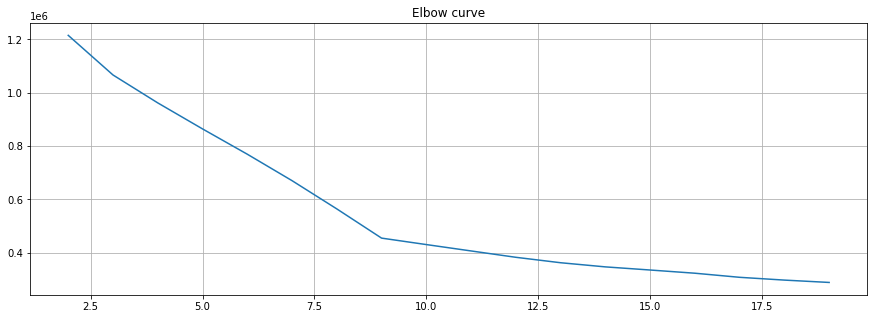

In [122]:
# Plot the elbow curve

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), sse)
plt.grid(True)
plt.title('Elbow curve')

As we can see from the elbow curve, *n_cluster* equals 8 is our optimal choice.

In [124]:
# Run kmeans clustering with n_cluster = 8

kmeans = KMeans(n_clusters=8)
kmeans.fit_transform(df_final)
clusters = kmeans.labels_

In [134]:
# Add clusters to the original data

df_cluster["cluster"] = clusters
loc_list = pd.read_csv("transactions_updated.csv")["location"]
df_cluster["locations"] = loc_list
df_cluster = df_cluster.drop(columns = locations) 

,shake,burger,fries,salad,day,time,cluster,locations
0,2,2,2,0,28,66780.0,1,4
1,0,1,3,2,18,43140.0,7,5
2,0,0,3,3,21,45600.0,6,3
3,0,0,4,4,21,44700.0,1,4
4,5,5,5,0,05,62460.0,3,7
...,...,...,...,...,...,...,...,...
99995,0,2,2,0,27,4620.0,4,6
99996,0,1,1,0,05,86340.0,4,6
99997,4,4,4,0,12,59340.0,7,8
99998,3,3,4,1,27,61560.0,5,9


In [139]:
# Turn seconds into hours

df_cluster['time'] = df_cluster["time"]/3600
df_cluster

,shake,burger,fries,salad,day,time,cluster,locations
0,2,2,2,0,28,18.550000,1,4
1,0,1,3,2,18,11.983333,7,5
2,0,0,3,3,21,12.666667,6,3
3,0,0,4,4,21,12.416667,1,4
4,5,5,5,0,05,17.350000,3,7
...,...,...,...,...,...,...,...,...
99995,0,2,2,0,27,1.283333,4,6
99996,0,1,1,0,05,23.983333,4,6
99997,4,4,4,0,12,16.483333,7,8
99998,3,3,4,1,27,17.100000,5,9


# Analysis

Now we can start analyze the clusters of customers we got.

In [141]:
df_cluster_grp = df_cluster.groupby("cluster")

In [177]:
# Build a function that automatically analyze each cluster

def customer_analysis(cluster):
    
    '''
    The input is the cluster number.
    Descriptive statistics will be printed in the process.
    '''
    
    df = df_cluster_grp.get_group(cluster)
    print("Let's examine customer data in cluster {}.".format(cluster))
    
    num = len(df)
    print("{:.2f}% of customers is segmented into cluster {}.".format(num/1000, cluster))
    
    means = df.mean()
    print("Every time, customers in cluster {} purchase an average of {:.1f} shakes, {:.1f} burgers, {:.1f} fries, and {:.1f} salad".format(cluster,means["shake"],means["burger"], means["fries"], means["salad"]))
    
    locs = df["locations"].value_counts()
    for i in locs.index:
        print("{:.2f}% of cluster {} customers are located in location {}.".format(locs[i]/num*100, cluster, i))
    
    print("\n")
    
    return

In [178]:
for i in range(8):
    customer_analysis(i)

Let's examine customer data in cluster 0.
15.77% of customers is segmented into cluster 0.
Every time, customers in cluster 0 purchase an average of 0.5 shakes, 1.8 burgers, 2.0 fries, and 0.2 salad
100.00% of cluster 0 customers are located in location 2.


Let's examine customer data in cluster 1.
11.34% of customers is segmented into cluster 1.
Every time, customers in cluster 1 purchase an average of 2.7 shakes, 3.0 burgers, 3.3 fries, and 0.4 salad
100.00% of cluster 1 customers are located in location 4.


Let's examine customer data in cluster 2.
8.68% of customers is segmented into cluster 2.
Every time, customers in cluster 2 purchase an average of 0.5 shakes, 0.9 burgers, 2.4 fries, and 1.5 salad
100.00% of cluster 2 customers are located in location 1.


Let's examine customer data in cluster 3.
11.24% of customers is segmented into cluster 3.
Every time, customers in cluster 3 purchase an average of 2.6 shakes, 2.9 burgers, 3.3 fries, and 0.4 salad
100.00% of cluster 3 cust

Next, we are interested in when customers of different clusters made their purchase.

C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

Text(0, 0.5, '# of Purchases')

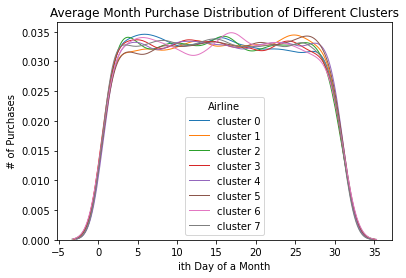

In [204]:
# Plot the average distribution of purchases for a month

for i in range(8):
    df = df_cluster_grp.get_group(i)
    cluster_name = "cluster {}".format(i)
    
    sns.distplot(df['day'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = cluster_name)

plt.legend(prop={'size': 10}, title = 'Airline')
plt.title('Average Month Purchase Distribution of Different Clusters')
plt.xlabel('ith Day of a Month')
plt.ylabel('# of Purchases')

As we can see from the distribution, purchases of customers of all clusters seems to be fairly uniformly distributed throughout a month.

C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

Text(0, 0.5, '# of Purchases')

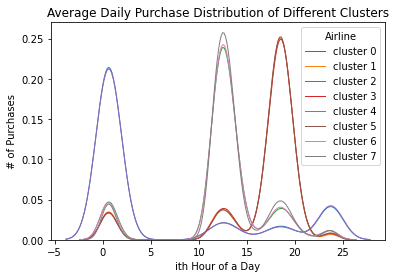

In [205]:
# Plot the average distribution of purchases for a day

for i in range(8):
    df = df_cluster_grp.get_group(i)
    cluster_name = "cluster {}".format(i)
    
    sns.distplot(df['time'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = cluster_name)

plt.legend(prop={'size': 10}, title = 'Airline')
plt.title('Average Daily Purchase Distribution of Different Clusters')
plt.xlabel('ith Hour of a Day')
plt.ylabel('# of Purchases')

We can learn a lot from this graph.<br>
First, we can see that business is very low between 5am. and 9am.<br>
Second, we can see three peaks at 0am., 12pm., and 7pm.<br>
Customers of Cluster 0 and 4 made majority of their purchases around midnight, let's call them 'Night Owl'.<br>
Customers of Cluster 2, 6, and 7 made majority of their purchase at noon, let's call them 'Fake Dieter'.<br>
Customers of Cluster 1, 3, and 5 made majority of their purchases at dinner time, 'Big Stomach'.<br>
Let's modify the plot with new names.

In [213]:
new_name = []
for i in df_cluster["cluster"]:
    if i in [0, 4]:
        cluster_name = "Night Owl"
    elif i in [2, 6, 7]:
        cluster_name = "Fake Dieter"
    elif i in [1, 3, 5]:
        cluster_name = "Big Stomach"
    new_name.append(cluster_name)

df_cluster["cluster_name"] = new_name

In [214]:
df_cluster

,shake,burger,fries,salad,day,time,cluster,locations,cluster_name
0,2,2,2,0,28,18.550000,1,4,Big Stomach
1,0,1,3,2,18,11.983333,7,5,Fake Dieter
2,0,0,3,3,21,12.666667,6,3,Fake Dieter
3,0,0,4,4,21,12.416667,1,4,Big Stomach
4,5,5,5,0,05,17.350000,3,7,Big Stomach
...,...,...,...,...,...,...,...,...,...
99995,0,2,2,0,27,1.283333,4,6,Night Owl
99996,0,1,1,0,05,23.983333,4,6,Night Owl
99997,4,4,4,0,12,16.483333,7,8,Fake Dieter
99998,3,3,4,1,27,17.100000,5,9,Big Stomach


In [215]:
df_cluster_3grp = df_cluster.groupby("cluster_name")
names = df_cluster["cluster_name"].unique()

C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\kongl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

Text(0, 0.5, '# of Purchases')

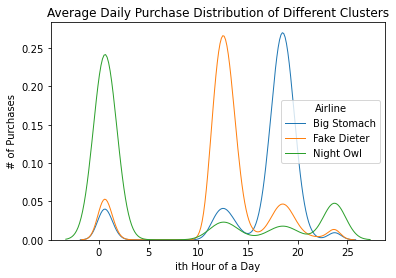

In [216]:
for name in names:
    df = df_cluster_3grp.get_group(name)
    
    sns.distplot(df['time'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = name)

plt.legend(prop={'size': 10}, title = 'Airline')
plt.title('Average Daily Purchase Distribution of Different Clusters')
plt.xlabel('ith Hour of a Day')
plt.ylabel('# of Purchases')